In [1]:
import numpy as np
from numpy.random import choice, randint, rand, uniform

import pdb

import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils.random import erdos_renyi_graph
from torch_geometric.utils import to_dense_adj, to_networkx, to_undirected

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import networkx as nx
import gym
from gym.spaces import Box, MultiDiscrete

from collections import namedtuple
from copy import copy, deepcopy
from typing import Optional
from enum import Enum, IntEnum
import sys
sys.path.append('/home/victorialena/rlkit')

import rlkit
from path_collector import MdpPathCollector

from any_replay_buffer import anyReplayBuffer

In [2]:
import time
start_time = time.time()

### env

In [3]:
device = 'cpu' #torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

In [4]:
sysconfig = namedtuple("sysconfig", 
                       ['maxX', 'maxY', 'goal_reward', 'collision_penalty'], 
                       defaults=[10, 10, 1., -.1])

In [5]:
actions = namedtuple("actions", 
                    ['right', 'left', 'up', 'down', 'noop'], 
                    defaults=[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)])
action = actions()
a2vecmap = torch.Tensor([[1., 0.],
                         [-1, 0.],
                         [0., 1.],
                         [0, -1.],
                         [0., 0.]]).to(device)

In [6]:
def fully_connect_graph(n_drones):
    """ Connect the graph s.t. all drones are interconnected and each goal connects to all drones. """
    
    idx = torch.combinations(torch.arange(n_drones+1), r=2)
    return to_undirected(idx.t(), num_nodes=n_drones+1)

In [7]:
class droneDeliveryProbe(gym.Env):
    """
    ### Description
    
    ### Action Space
    Each agent in the scene can move R or L or not at all.
    
    ### State Space
    The state is defined as an arbitrary input array of positions of n drones, appended by the location
    of the goal region.
    
    ### Rewards
    The reward of +1 is given to the system for each drone reaching the goal region.
    
    ### Starting State
    Randomly initilized input array.
    
    ### Episode Termination
    When all drones have reached the goal region.
    
    ### Arguments
    No additional arguments are currently supported.
    """

    def __init__(self, n=1, device='cpu'):
        self.config = sysconfig()
        self.ndrones = n
        
        self.aspace = MultiDiscrete([len(action)]*self.ndrones)
        self.sspace = MultiDiscrete([self.config.maxX, self.config.maxY, 2])
        self.state = None
        
        self._device = device
        
    def get_distances(self):
        return (self.state.x[-1, :-1]-self.state.x[:-1, :-1]).norm(p=1, dim=1)
    
    def in_collision(self):
        dis = torch.cdist(self.state.x[:-1, :-1], self.state.x[:-1, :-1], p=1)
        return torch.triu((dis == 0).float(), 1).sum().item()
    
    def get_size(self):
        return torch.Tensor([self.config.maxX, self.config.maxY, 2])
        
    def reward(self, a):
        return self.config.goal_reward * (self.get_distances() == 0).all().float().item() + \
                self.config.collision_penalty * self.in_collision()
                        
    def step(self, a):
        err_msg = f"{a!r} ({type(a)}) is not a valid action."
        assert self.aspace.contains(a), err_msg
        
        reward = self.reward(a)
        a = a2vecmap[a]
        done = (self.get_distances() == 0).all().item()   
    
        self.state.x[:-1, :-1] = (self.state.x[:-1, :-1]+a).clamp(min=0, max=self.config.maxX)
        
        return deepcopy(self.state), deepcopy(reward), deepcopy(done), {}

    def reset(self, seed: Optional[int] = None):
        if not seed == None:
            super().reset(seed=seed)
            
        x = torch.Tensor(np.stack([self.sspace.sample() for _ in range(self.ndrones+1)]))
        # reset the state flags: +1 agent, -1 goal
        x[:, -1] = 1
        x[-1, -1] = -1
        
        edge_index = fully_connect_graph(self.ndrones)
        self.state = Data(x=x, edge_index=edge_index).to(device)
        
        return deepcopy(self.state)

    def render(self, s = None):
        if not s:
            s = self.state
        g = torch_geometric.utils.to_networkx(s, to_undirected=False)
        colors = np.array(['green']*self.ndrones+['yellow'])
        pos = {i: x[:2].numpy() for i, x in enumerate(self.state.x)}
        nx.draw(g, pos=pos, node_color=colors)
    
    def seed(self, n: int):
        super().seed(n)
        self.aspace.seed(n)
        self.sspace.seed(n)
        
    def to(self, device):
        self._device = device
        if self.state:
            self.state = self.state.to(device)

In [8]:
env = droneDeliveryProbe(2, device=device)
x = env.reset()

### Model

In [9]:
from collections import OrderedDict

from torch.nn import Linear, ReLU, Softmax
import torch.nn.functional as F
from torch_geometric.nn import Sequential, GCNConv, SAGEConv
        
class droneDeliveryModel(nn.Module):
    
    def __init__(self, c_in, c_out, c_hidden=64, bounds=None, **kwargs):
        
        super().__init__()
        
        self.model = Sequential('x, edge_index', [
            (SAGEConv(c_in, c_hidden), 'x, edge_index -> x'),
            ReLU(inplace=True),
            (SAGEConv(c_hidden, c_hidden), 'x, edge_index -> x'),
            ReLU(inplace=True),
            (SAGEConv(c_hidden, c_hidden), 'x, edge_index -> x'),
            ReLU(inplace=True),
            Linear(c_hidden, c_out),
#             nn.Softmax(dim=-1) # no freaking softmax
        ])
        
        self._device = 'cpu'
        self._upper_bound = bounds

    def forward(self, x):
        y = x.x
        if self._upper_bound is not None:
            y = y.div(self._upper_bound-1)
        return self.model(y, x.edge_index)[:-1]
    
    def to(self, device):
        super().to(device)
        self._device = device
        if self._upper_bound is not None:
            self._upper_bound = self._upper_bound.to(device)

In [10]:
in_channels, out_channels = 2+1, len(action)

### RL 

In [11]:
max_len = env.config.maxX + env.config.maxY - 1

In [12]:
def pick(x):
    probs = np.array([x[0]>0, x[0]<0, x[1]>0, x[1]<0, x[1]==x[0]==0], dtype=int)
    return np.random.choice(action, p=probs/sum(probs))

In [13]:
from rlkit.policies.base import Policy

class sysRolloutPolicy(nn.Module, Policy):
    def __init__(self):
        super().__init__()

    def get_action(self, obs):
        dis = (obs.x[-1] - obs.x[:-1])
        return [pick(d) for d in dis], {}
    
class argmaxDiscretePolicy(nn.Module, Policy):
    def __init__(self, qf, dim=1):
        super().__init__()
        self.qf = qf
        self.dim = dim

    def get_action(self, obs):
        q_values = self.qf(obs)
        return q_values.cpu().detach().numpy().argmax(self.dim), {}

# redundant code - clean this up
class epsilonGreedyPolicy(nn.Module, Policy):
    def __init__(self, qf, space, eps=0.1, dim=1, sim_annealing_fac=1.0):
        super().__init__()
        self.qf = qf
        self.aspace = space
        
        self.eps = eps
        self.dim = dim
        self.saf = sim_annealing_fac
        
    def simulated_annealing(self):
        self.eps *= self.saf

    def get_action(self, obs):
        if rand() < self.eps:
            return self.aspace.sample(), {}
        q_values = self.qf(obs)
        return q_values.cpu().detach().numpy().argmax(self.dim), {}

In [14]:
def mean_reward_per_traj(paths):
    return np.mean([np.sum(p['rewards']) for p in paths])

def mean_reward(paths):
    return np.hstack([p['rewards'] for p in paths]).mean()

#### train

In [15]:
RANDOM_SEED = 0

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
env.seed(RANDOM_SEED)

In [16]:
qf = droneDeliveryModel(in_channels, out_channels, 32, bounds=env.get_size())
qf.load_state_dict(torch.load('qf_multi_norm_heterogen2.pt'))
qf.to(device)

target_qf = droneDeliveryModel(in_channels, out_channels, 32, bounds=env.get_size())
target_qf.load_state_dict(torch.load('qf_multi_norm_heterogen2.pt'))
target_qf.to(device)

In [17]:
qf_criterion = nn.MSELoss()
eval_policy = argmaxDiscretePolicy(qf)
# expl_policy = sysRolloutPolicy()
# expl_policy = epsilonGreedyPolicy(qf, env.aspace, eps=.1)
expl_policy = epsilonGreedyPolicy(qf, env.aspace, eps=.1, sim_annealing_fac=.98)

In [18]:
replay_buffer_cap = 1000 # 256

In [19]:
expl_path_collector = MdpPathCollector(env, expl_policy) 
eval_path_collector = MdpPathCollector(env, eval_policy)
replay_buffer = anyReplayBuffer(replay_buffer_cap, prioritized=True)
optimizer = Adam(qf.parameters(), lr=1E-3)

In [20]:
n_epoch = 15
n_iter = 100
batch_size = 256 #128
n_samples = replay_buffer_cap//max_len #256
γ = 0.95

loss = []
avg_r_train = []
avg_r_test = []

for i in range(n_epoch):
    qf.train(False)
    paths = eval_path_collector.collect_new_paths(128, max_len, False)
    avg_r_test.append(mean_reward_per_traj(paths))
    
    paths = expl_path_collector.collect_new_paths(n_samples, max_len, False)
    replay_buffer.add_paths(paths) 
    
    qf.train(True)
    if n_epoch > 0:
        expl_path_collector._policy.simulated_annealing()
        
    for _ in range(n_iter):
        batch = replay_buffer.random_batch(batch_size)
        rewards = torch.Tensor(batch['rewards']).unsqueeze(-1).to(device)
        terminals = torch.Tensor(batch['terminals']).unsqueeze(-1).to(device)
        actions = torch.Tensor(batch['actions']).to(device)

        obs = batch['observations']
        next_obs = batch['next_observations']
                
        out = torch.stack(list(map(target_qf, next_obs)), axis=0)         
        target_q_values = out.max(-1, keepdims=False).values
        y_target = rewards + (1. - terminals) * γ * target_q_values 
        out = torch.stack(list(map(qf, obs)), axis=0)
               
        actions_one_hot = F.one_hot(actions.to(torch.int64), len(action))
        y_pred = torch.sum(out * actions_one_hot, dim=-1, keepdim=False)
        qf_loss = qf_criterion(y_pred, y_target)
        
        loss.append(qf_loss.item())
        avg_r_train.append(rewards.mean().item())
        
        optimizer.zero_grad() 
        qf_loss.backward()
        optimizer.step()
        
#     print(qf.state_dict().items())
    
    target_qf.load_state_dict(deepcopy(qf.state_dict()))
    print("iter ", i+1, " -> loss: ", np.mean(loss[-n_iter:]),
          ", rewards: (train) ", np.mean(avg_r_train[-n_iter:]),
          ", (test) ", avg_r_test[-1])

iter  1  -> loss:  0.0010192688106326385 , rewards: (train)  0.09068359043449163 , (test)  0.32109375000000007
iter  2  -> loss:  0.0007614722929429263 , rewards: (train)  0.09696874815970659 , (test)  0.45625000000000004
iter  3  -> loss:  0.0006352534392499365 , rewards: (train)  0.1088632795214653 , (test)  0.6625000000000001
iter  4  -> loss:  0.0006866937811719254 , rewards: (train)  0.13312890343368053 , (test)  0.6914062500000002
iter  5  -> loss:  0.0007302904647076503 , rewards: (train)  0.11457030884921551 , (test)  0.36015625000000007
iter  6  -> loss:  0.0007108768058242276 , rewards: (train)  0.12510155960917474 , (test)  0.7453125000000002
iter  7  -> loss:  0.0007225822165491991 , rewards: (train)  0.12905859120190144 , (test)  0.5835937500000001
iter  8  -> loss:  0.0006184916204074398 , rewards: (train)  0.12312109097838402 , (test)  0.6585937500000002
iter  9  -> loss:  0.0008671935985330492 , rewards: (train)  0.08473437137901783 , (test)  0.5296875000000001
iter  10

In [21]:
print("This eval took me ", time.time() - start_time, " seconds. Thanks for waiting :)")

This eval took me  506.5519218444824  seconds. Thanks for waiting :)


In [22]:
torch.save(qf.state_dict(), "qf_multi_norm_heterogen3.pt")

#### Plots

In [26]:
import matplotlib.pyplot as plt

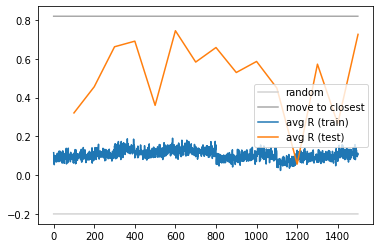

In [27]:
plt.plot(np.arange(n_iter*n_epoch), [-0.2]*(n_iter*n_epoch), label = "random", color='lightgray')
plt.plot(np.arange(n_iter*n_epoch), [0.82]*(n_iter*n_epoch), label = "move to closest",  color='darkgray')

plt.plot(np.arange(n_iter*n_epoch), avg_r_train, label = "avg R (train)")
plt.plot(np.arange(n_iter, n_iter*n_epoch+1, step=n_iter), avg_r_test, label = "avg R (test)")
plt.legend()

plt.savefig('training_log.png', dpi=300)

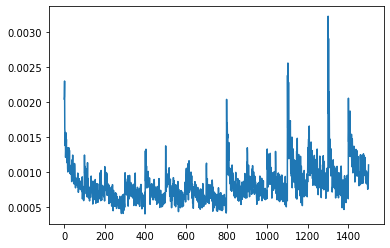

In [25]:
plt.plot(loss)